### Conditional random field: Fit and evaluate the Tagger [sklearn-crfsuite](https://sklearn-crfsuite.readthedocs.io/en/latest/)

In this notebook, we will fit and evaluate the Conditional random field tagger.

### Overview

- [Loading required packages](#Loading-required-packages)
- [Read the corpus](#Read-the-corpus)
- [Spliting the data into three different sets](#Spliting-the-data-into-three-different-sets)
- [Feature extraction](#Feature-extraction)`

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn_crfsuite import CRF
import scipy
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import warnings

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


import re
from time import time
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
corpus = pd.read_excel('corpus.xlsx')
corpus.head()

,token,tag,pos
0,امریکایي,ADJ,adjective
1,فضانوردې,NOUN,noun
2,کریستینا کوچ,NOUN,noun
3,،,PUNCT,punctuation
4,په,PRT,particle


In [3]:
tokens = []
tags = []
sents = []
for i, token, tag, pos in corpus.itertuples():
    tokens.append(token)
    tags.append(tag)
    if (token == '.'):
        sents.append((tokens, tags))
        tokens = []
        tags = []
        continue

In [4]:
print('Number of words in the corpus: {}'.format(len(corpus['token'])))
print('Number of sentences in the corpus: {}'.format(len(sents)))

Number of words in the corpus: 41928
Number of sentences in the corpus: 1219


### Feature extraction 

In [5]:
def extract_features(sentence, index):
  """Extract features of given word(token)"""
  return {
      'token':sentence[index],
      'is_first':index==0,
      'is_last':index ==len(sentence)-1,
  
      'prefix-1':sentence[index][0],
      'prefix-2':sentence[index][:2],
      'prefix-3':sentence[index][:3],
      'prefix-3':sentence[index][:4],
      'suffix-1':sentence[index][-1],
      'suffix-2':sentence[index][-2:],
      'suffix-3':sentence[index][-3:],
      'suffix-3':sentence[index][-4:],
      
      'prev_word':'' if index == 0 else sentence[index-1],
      '2-prev-token': '' if index <= 1     else sentence[index - 2],
      
      
      'next_word':'' if index == len(sentence) - 1     else sentence[index + 1],
      '2-next-token': '' if index >= len(sentence) - 2     else sentence[index + 2],
      
      'has_hyphen': '-' in sentence[index],
      'is_numeric': sentence[index].isdigit(),

  }

In [6]:
def transform_to_dataset(tagged_sentences):
  X, y = [], []
  for sentence, tags in tagged_sentences:

    sent_word_features, sent_tags = [],[]
    for index in range(len(sentence)):
        sent_word_features.append(extract_features(sentence, index)),
        sent_tags.append(tags[index])
    X.append(sent_word_features)
    y.append(sent_tags)
  return X, y

In [7]:
train_size = int(0.6*len(sents))
train = sents[:train_size]
testing = sents[train_size:]
test_size = int(0.5*len(testing))
test = testing[:test_size]
val = testing[test_size:]

In [8]:
X_train, y_train = transform_to_dataset(train)
X_test, y_test = transform_to_dataset(test)
X_val, y_val = transform_to_dataset(val)

In [9]:
crf = CRF(
    #max_iterations=100,
    all_possible_transitions=True,
    algorithm = 'lbfgs',
    max_iterations = 150
)

In [10]:
parameters = {
    'c1': [0.01, 0.1, 0],
    'c2': [0.01, 0.2, 1],
}

In [11]:
labels = corpus['tag'].unique()


In [12]:
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='macro', labels=labels)

accuray_scorer = make_scorer(metrics.flat_accuracy_score,
                        average='macro', labels=labels)

In [20]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    test_means = results.cv_results_['mean_test_score']
    test_stds = results.cv_results_['std_test_score']
    
    train_means = results.cv_results_['mean_train_score']
    train_stds = results.cv_results_['std_train_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(test_mean, 4), round(test_std * 2, 4), params))

In [14]:
cv = GridSearchCV(crf, parameters,
                  cv=5,
                  verbose=1,
                  n_jobs=-1,
                  scoring=f1_scorer)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.3min finished


BEST PARAMS: {'c1': 0.1, 'c2': 0.01}

0.9487 (+/-0.0541) for {'c1': 0.01, 'c2': 0.01}
0.9344 (+/-0.0658) for {'c1': 0.01, 'c2': 0.2}
0.9105 (+/-0.0675) for {'c1': 0.01, 'c2': 1}
0.9576 (+/-0.0554) for {'c1': 0.1, 'c2': 0.01}
0.9382 (+/-0.0625) for {'c1': 0.1, 'c2': 0.2}
0.9085 (+/-0.0642) for {'c1': 0.1, 'c2': 1}
0.9432 (+/-0.0594) for {'c1': 0, 'c2': 0.01}
0.9338 (+/-0.0662) for {'c1': 0, 'c2': 0.2}
0.9106 (+/-0.0681) for {'c1': 0, 'c2': 1}


In [21]:
print_results(cv)

BEST PARAMS: {'c1': 0.1, 'c2': 0.01}



KeyError: 'mean_train_score'

In [22]:
print(cv.cv_results_['split0_test_score'])

[0.89543544 0.87034858 0.84383709 0.90224403 0.87647432 0.84587664
 0.88549086 0.86951627 0.84331441]


In [23]:
print(cv.cv_results_)

{'mean_fit_time': array([6.43063798, 7.12825656, 4.98480368, 8.39421525, 6.51286116,
       4.42350392, 7.58642888, 6.23205104, 4.2635829 ]), 'std_fit_time': array([0.37580038, 0.67485733, 0.37262965, 0.56785963, 0.68536766,
       0.43292632, 0.26498371, 0.32461095, 0.26660817]), 'mean_score_time': array([0.13861952, 0.16821918, 0.16372528, 0.1489419 , 0.14946804,
       0.14990993, 0.16099858, 0.15844607, 0.14244075]), 'std_score_time': array([0.01638995, 0.03601434, 0.03095105, 0.02112651, 0.02711854,
       0.02103823, 0.02030916, 0.02098811, 0.02754041]), 'param_c1': masked_array(data=[0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0, 0, 0],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_c2': masked_array(data=[0.01, 0.2, 1, 0.01, 0.2, 1, 0.01, 0.2, 1],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
        

In [23]:
joblib.dump(cv.best_estimator_, './models/crf_model.pkl')

['./models/crf_model.pkl']

In [24]:
crf_tagger = joblib.load('./models/crf_model.pkl')

In [35]:
start = time()
pred_val = crf_tagger.predict(X_val)
end = time()

In [42]:
f1score = round(metrics.flat_f1_score(y_val, pred_val,
                               average='macro', labels=labels), 4)

accuracy = round(metrics.flat_accuracy_score(y_val, pred_val), 4)

precision = round(metrics.flat_precision_score(y_val, pred_val,
                      average='macro', labels=labels), 4)

recall = round(metrics.flat_recall_score(y_val, pred_val,
                      average='macro', labels=labels), 4)


In [43]:
print('F1-Score: {} '.format(f1score))
print('Accuracy: {} '.format(accuracy))
print('Precision: {} '.format(precision))
print('Recall: {} '.format(recall))
print('Latency: {}ms'.format(round((end - start)*1000, 1)))

F1-Score: 0.9663 
Accuracy: 0.9593 
Precision: 0.9829 
Recall: 0.9531 
Latency: 155.6ms


### confusion matrix

In [46]:
#print(classification_report(y_val, pred_val, target_names=corpus['tag'].unique()))
clf_report = metrics.flat_classification_report(y_val, 
                                   pred_val, 
                                   target_names=sorted(labels),
                                   labels=sorted(labels),
                                   output_dict=True)

In [47]:
sns.set('paper', 'white',
        rc={'font.size': 10, 'axes.labelsize': 10,
            'legend.fontsize': 10, 'axes.titlesize': 10,
            'xtick.labelsize': 10,'ytick.labelsize': 10, 
            "pgf.rcfonts": True,
           })
plt.rc('font', **{'family': 'serif', 'serif': ['Times']})
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

<Figure size 432x288 with 0 Axes>

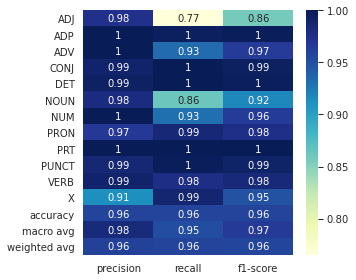

In [97]:
plt.figure(figsize=(5, 4))
fig = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T,
                  annot=True, annot_kws={'size': 10},
                  cbar=1,
                  linewidths=0,
                  linecolor='white',
                  cmap="YlGnBu"
                  )


In [98]:
f = fig.get_figure()
f.autolayout : True
f.savefig('crf_matrix1.png', dpi=400)

### second


In [75]:
from sklearn.metrics import confusion_matrix
from cf_matrix import make_confusion_matrix
categories = sorted(labels)

In [86]:
from itertools import chain
f_y_val = list(chain.from_iterable(y_val))
f_pred_val = list(chain.from_iterable(pred_val))

In [89]:
confusion_matrix = confusion_matrix(f_y_val, f_pred_val, normalize='true', labels=categories)

In [90]:
vminn = np.min(confusion_matrix)
vmaxx = np.max(confusion_matrix)

Text(0.5, 6.799999999999994, 'Predicted')

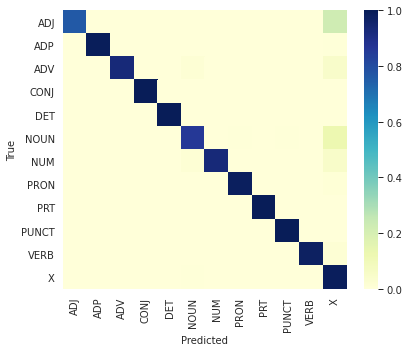

In [116]:
plt.figure(figsize=(6, 5))
fig = sns.heatmap(confusion_matrix,
                  annot=False, annot_kws={'size': 10},
                  vmax=vmaxx,
                  vmin=vminn,
                  cbar=True,
                  linewidths=0,
                  linecolor='white',
                  cmap="YlGnBu",
                  #fmt='',
                  xticklabels=categories,
                  yticklabels=categories,
                  #cbar_kws={'ticks':[]}
                  )
plt.ylabel('True')
plt.xlabel('Predicted')

#cbar = fig.collections[0].colorbar
#cbar.set_ticks([0, .2, .4, .6, .8, 1])
#cbar.set_ticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])



In [117]:
f = fig.get_figure()
f.autolayout : True
f.savefig('crf_matrix2.png', dpi=400)